<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_02/exercises/exercise_02_4dstem_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 02: 4D-STEM Fundamentals

Hands-on practice with 4D-STEM data creation, virtual detectors, and calibration.


## Exercise 1: Creating Synthetic 4D-STEM Data

**Task:**
1. Import py4DSTEM.
2. Create a synthetic 4D-STEM dataset (e.g., 10x10 scan positions, 64x64 diffraction pattern).
3. Add some features like a central beam and diffraction spots.
4. Print the dataset shape and axes information.

In [1]:
# Problem set-up
import py4DSTEM
import numpy as np
from py4DSTEM import DataCube

# Create a synthetic dataset
nx, ny = 10, 10 # real-space scan dimensions
qx, qy = 64, 64 # diffraction pattern dimensions

data = np.zeros((ny, nx, qy, qx))

# Diffraction-space coordinates
Y, X = np.meshgrid(np.arange(qy),np.arange(qx), indexing="ij")

cx, cy = qx // 2, qy // 2 # center of diffraction pattern

# Fill dataset
for iy in range(ny):
    for ix in range(nx):

        # Central beam (broad Gaussian)
        data[iy, ix] += np.exp(-((X - cx)**2 + (Y - cy)**2) / 20)

        # Add diffraction spots
        data[iy, ix] += np.exp(-((X - (cx + 10))**2 + (Y - cy)**2) / 2)
        data[iy, ix] += np.exp(-((X - (cx - 10))**2 + (Y - cy)**2) / 2)
        data[iy, ix] += np.exp(-((X - cx)**2 + (Y - (cy + 10))**2) / 2)
        data[iy, ix] += np.exp(-((X - cx)**2 + (Y - (cy - 10))**2) / 2)

        data[iy, ix] *= (1 + 0.1 * ix)
        
# Wrap as a py4DSTEM DataCube

dc = DataCube(data)

# Inspect dataset
print("Data shape:", dc.shape)
print("Scan axes (y, x):",dc.shape[:2])
print("Diffraction axes (qy, qx):",dc.shape[2:])

Data shape: (10, 10, 64, 64)
Scan axes (y, x): (10, 10)
Diffraction axes (qy, qx): (64, 64)


In [2]:
print("Sum at (iy=0, ix=0):", dc.data[0, 0].sum())
print("Sum at (iy=0, ix=9):", dc.data[0, 9].sum())

Sum at (iy=0, ix=0): 87.96459456946349
Sum at (iy=0, ix=9): 167.13272968198063


## Exercise 2: Navigation vs Signal Axes

**Task:**
1. Using your synthetic dataset, identify and print the navigation axes.
2. Identify and print the signal axes.
3. Verify the total dimensionality.
4. Explain the difference between navigation and signal axes in 4D-STEM.

In [3]:
# Problem set-up
import py4DSTEM
import numpy as np
from py4DSTEM import DataCube

# Navigation axes: first two dimensions
navigation_axes = dc.shape[:2]
print("Navigation axes (scan positions):", navigation_axes)

# Signal axes: last two dimensions
signal_axes = dc.shape[2:]
print("Signal axes (diffraction pattern):", signal_axes)

# Total dimensionality
total_dims = dc.data.ndim
print("Total dimensionality:", total_dims)

Navigation axes (scan positions): (10, 10)
Signal axes (diffraction pattern): (64, 64)
Total dimensionality: 4


### Explanation: navigation vs signal axes
- Navigation axes represent where the electron probe is positioned in real space (ny, nx). So, the probe scans a 10x10 grid.
- Signal axes represent the detector output, i.e., the diffraction pattern (qy, qx). Each scan position produces a 64x64 diffraction image.
- A 4D-STEM dataset is essentially a stack of diffraction patterns, indexed by probe position. 
 
Navigation axes = the indexing grid

Signal axes = the measured data at each point

## Exercise 3: Virtual Detectors

**Task:**
1. Define a Bright Field (BF) virtual detector (central disk).
2. Define an Annular Dark Field (ADF) virtual detector (outer ring).
3. Generate BF and ADF images from your dataset.
4. Plot both images side by side.

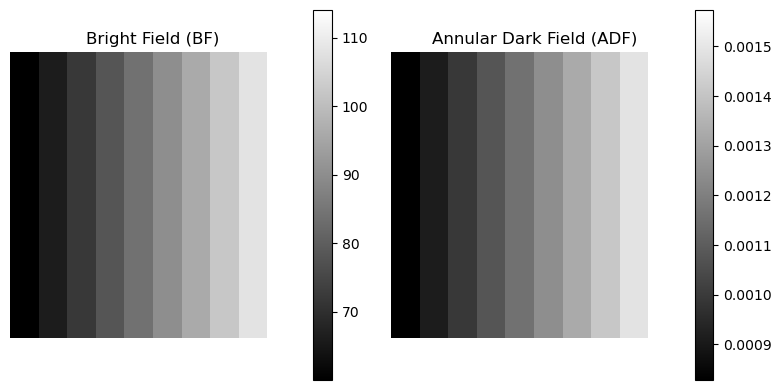

Unique BF values: [ 60.03813227  66.04194549  72.04575872  78.04957195  84.05338518
  90.0571984   96.06101163 102.06482486 108.06863808 114.07245131]


In [4]:
# Problem set-up
import matplotlib.pyplot as plt
import numpy as np
from py4DSTEM import DataCube

ny, nx, qy, qx = dc.data.shape

# Define diffraction-space coordinates
Y, X = np.meshgrid(np.arange(qy),np.arange(qx),indexing="ij")
cx, cy = qx // 2, qy // 2

R = np.sqrt((X - cx)**2 + (Y - cy)**2)

# Define virtual detectors
# Bright Field (central disk)
bf_radius = 8
BF_detector = R < bf_radius

# Annual Dark Field (outer ring)
adf_inner = 15
adf_outer = 25
ADF_detector = (R > adf_inner) & (R < adf_outer)

# Generate BF and ADF images
BF_image = np.zeros((ny,nx))
ADF_image = np.zeros((ny,nx))

for iy in range(ny):
    for ix in range(nx):
        pattern = dc.data[iy, ix]
        BF_image[iy, ix] = np.sum(pattern[BF_detector])
        ADF_image[iy, ix] = np.sum(pattern[ADF_detector])

# Plot BF and ADF images side by side
plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)
plt.imshow(BF_image, cmap="gray")
plt.colorbar()
plt.title("Bright Field (BF)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ADF_image, cmap="gray")
plt.colorbar()
plt.title("Annular Dark Field (ADF)")
plt.axis("off")

plt.tight_layout()
plt.show()

# Verification
print("Unique BF values:", np.unique(BF_image))

In [5]:
print("BF min / max:", BF_image.min(), BF_image.max())
print("ADF min / max:", ADF_image.min(), ADF_image.max())

BF min / max: 60.038132268137275 114.07245130946083
ADF min / max: 0.0008280796698074222 0.0015733513726341021


In [6]:
# Sanity check: does BF signal vary?
print("BF row 0:", BF_image[0])
print("BF min/max:", BF_image.min(), BF_image.max())
print("Relative variation:", BF_image.max() / BF_image.min())

BF row 0: [ 60.03813227  66.04194549  72.04575872  78.04957195  84.05338518
  90.0571984   96.06101163 102.06482486 108.06863808 114.07245131]
BF min/max: 60.038132268137275 114.07245130946083
Relative variation: 1.9000000000000001


## Exercise 4: Basic Calibration

**Task:**
1. Set the scan step size for your dataset (e.g., 1 nm).
2. Set the diffraction pattern pixel size (e.g., 0.01 1/Å).
3. Print the calibrated axes information.
4. Discuss why calibration is important in 4D-STEM.

In [9]:
# Problem set-up
import numpy as np

ny, nx, qy, qx = dc.data.shape

# Set the scan step size
scan_step_nm = 1.0 # nm per scan pixel

y_real_nm = np.arange(ny) * scan_step_nm
x_real_nm = np.arange(nx) * scan_step_nm

# Set diffraction pattern pixel size
diff_pixel_size_invA = 0.01 #1/Angstrom per diffraction pixel

# Center diffraction axes at zero
qy_center = qy // 2
qx_center = qx // 2

qy_recip_invA = (np.arange(qy) - qy_center) * diff_pixel_size_invA
qx_recip_invA = (np.arange(qx) - qx_center) * diff_pixel_size_invA

# Print calibrated axes information
print("=== Calibrated Navigation Axes (Real Space) ===")
print("y-axis (nm):", y_real_nm)
print("x-axis (nm):", x_real_nm)

print("\n=== Calibrated Signal Axes (Reciprocal Space) ===")
print("qy-axis (1/Å):",qy_recip_invA)
print("qx-axis (1/Å):",qx_recip_invA)

#Verify dimensionality with calibrated context
print("\n=== Dataset Summary ===")
print("Total dimensions:", dc.data.ndim)
print("Navigation dimensions:", (ny,nx))
print("Signal dimensions:",(qy,qx))

=== Calibrated Navigation Axes (Real Space) ===
y-axis (nm): [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
x-axis (nm): [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]

=== Calibrated Signal Axes (Reciprocal Space) ===
qy-axis (1/Å): [-0.32 -0.31 -0.3  -0.29 -0.28 -0.27 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21
 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09
 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01  0.    0.01  0.02  0.03
  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11  0.12  0.13  0.14  0.15
  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23  0.24  0.25  0.26  0.27
  0.28  0.29  0.3   0.31]
qx-axis (1/Å): [-0.32 -0.31 -0.3  -0.29 -0.28 -0.27 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21
 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09
 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01  0.    0.01  0.02  0.03
  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11  0.12  0.13  0.14  0.15
  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23  0.24  0.25  0.26  0.27
  0.28  0.29  0.3   0.31]

## Exercise 5: Data Visualization

**Task:**
1. Plot a single diffraction pattern from your dataset.
2. Create a simple animation or plot showing variation across scan positions.
3. Save one of your plots as a high-quality image.

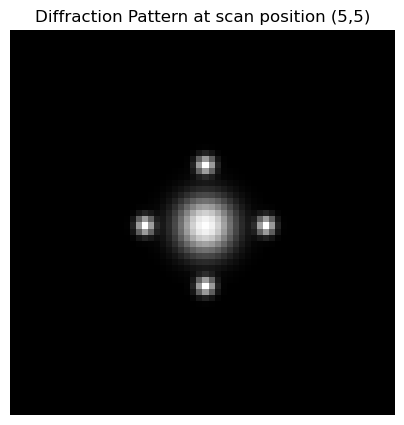

Animation displayed, static frame suppressed.
Saved: diffraction_pattern_high_quality.png


In [27]:
# Problem set-up
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

ny, nx, qy, qx = dc.data.shape

# Plot single diffraction pattern
iy, ix = 5, 5 # Center scan position

plt.figure(figsize=(5,5))
plt.imshow(dc.data[iy,ix],cmap="gray")
plt.title(f"Diffraction Pattern at scan position ({iy},{ix})")
plt.axis("off")
plt.show()

# Create simple animation showing scan variation
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(dc.data[0,0],cmap="gray")
ax.axis("off")

def update(frame):
    iy = frame // nx
    ix = frame % nx
    im.set_data(dc.data[iy,ix])
    ax.set_title(f"Scan position ({iy},{ix})")
    return [im]

ani = FuncAnimation(fig, update, frames=ny*nx, interval=150, blit=True)

display(HTML(ani.to_jshtml()))
plt.close(fig)
print("Animation displayed, static frame suppressed.")

# Save a high quality image
plt.figure(figsize=(6,6))
plt.imshow(dc.data[iy,ix],cmap="gray")
plt.axis("off")
plt.title("Diffraction Pattern at scan position ({iy},{ix})")

plt.savefig("diffraction_pattern_high_quality.png",dpi=300, bbox_inches="tight")
plt.close()

print("Saved: diffraction_pattern_high_quality.png")

In [29]:
# Problem set-up
from matplotlib.animation import FuncAnimation

# Save animation as GIF (cannot save as MP4 in current environment)
ani.save("scan_animation.gif", writer="pillow", fps=5)
print("Saved: scan_animation.gif")

Saved: scan_animation.gif
